<a href="https://colab.research.google.com/github/Yash070803/NoteBooks/blob/main/Forecasting_AirLine_Prices(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the train dataset
train_data = pd.read_csv('train.csv')
train_data.head()

,Flight_ID,Airline,Departure_City,Arrival_City,Distance,Departure_Time,Arrival_Time,Duration,Aircraft_Type,Number_of_Stops,Day_of_Week,Month_of_Travel,Holiday_Season,Demand,Weather_Conditions,Passenger_Count,Promotion_Type,Fuel_Price,Flight_Price
0,F1,Airline B,NaN,Greenshire,8286.0,8:23,20:19,11.94,Boeing 787,0,Wednesday,December,Summer,Low,Rain,240,Special Offer,0.91,643.93
1,F2,Airline C,Leonardland,New Stephen,2942.0,20:28,1:45,5.29,Airbus A320,0,Wednesday,March,Spring,Low,Rain,107,None,1.08,423.13
2,F3,Airline B,South Dylanville,Port Ambermouth,2468.0,11:30,15:54,4.41,Boeing 787,1,Sunday,September,Summer,High,Cloudy,131,NaN,0.52,442.17
3,F4,NaN,Blakefort,Crosbyberg,3145.0,20:24,1:21,4.96,Boeing 787,0,Sunday,February,Fall,Low,Cloudy,170,Discount,0.71,394.42
4,F5,Airline B,Michaelport,Onealborough,5558.0,21:59,6:04,8.09,Boeing 737,1,Thursday,January,None,NaN,Clear,181,None,1.09,804.35


In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [4]:
def preprocess_data(data):
    # Fill missing values
    data['Airline'].fillna('Unknown', inplace=True)
    data['Departure_City'].fillna('Unknown', inplace=True)
    data['Demand'].fillna('Unknown', inplace=True)
    data['Promotion_Type'].fillna('None', inplace=True)

    # Convert categorical variables into numerical representations using Label Encoding
    label_columns = ['Airline', 'Departure_City', 'Arrival_City', 'Aircraft_Type', 'Day_of_Week',
                     'Month_of_Travel', 'Holiday_Season', 'Demand', 'Weather_Conditions', 'Promotion_Type']

    le = LabelEncoder()
    for column in label_columns:
        data[column] = le.fit_transform(data[column])

    # Normalize or standardize features
    scaler = StandardScaler()
    data[['Distance', 'Duration', 'Fuel_Price']] = scaler.fit_transform(data[['Distance', 'Duration', 'Fuel_Price']])

    return data

# Apply preprocessing to the train dataset
train_data_preprocessed = preprocess_data(train_data)
train_data_preprocessed.head()

,Flight_ID,Airline,Departure_City,Arrival_City,Distance,Departure_Time,Arrival_Time,Duration,Aircraft_Type,Number_of_Stops,Day_of_Week,Month_of_Travel,Holiday_Season,Demand,Weather_Conditions,Passenger_Count,Promotion_Type,Fuel_Price,Flight_Price
0,F1,1,20656,5763,1.080523,8:23,20:19,1.241312,4,0,6,2,3,1,2,240,2,0.296470,643.93
1,F2,2,9554,12751,-0.978966,20:28,1:45,-0.778220,0,0,6,7,2,1,2,107,1,1.139162,423.13
2,F3,1,18756,15392,-1.161637,11:30,15:54,-1.045466,4,1,3,11,3,0,1,131,1,-1.636767,442.17
3,F4,3,1000,2425,-0.900733,20:24,1:21,-0.878437,4,0,3,3,0,1,1,170,0,-0.694934,394.42
4,F5,1,10526,14858,0.029197,21:59,6:04,0.072109,2,1,4,4,1,3,0,181,1,1.188733,804.35


In [5]:
!pip install -q xgboost

In [6]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [7]:
# Splitting data into features and target
X = train_data_preprocessed.drop(columns=['Flight_ID', 'Departure_Time', 'Arrival_Time', 'Flight_Price'])
y = train_data_preprocessed['Flight_Price']

In [8]:
# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Training the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05)
model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_val, y_val)], verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
# Predicting on validation set
y_pred = model.predict(X_val)

In [11]:
# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

12.939355754184977

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [13]:
# Define the hyperparameters and their distributions
param_dist = {
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 11),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'n_estimators': [500, 1000],
    'gamma': uniform(0, 0.3)
}

In [14]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

In [15]:
# Set up the randomized search with 50 iterations
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=50,
                                   scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, cv=3, random_state=42)

In [ ]:
# Fit the randomized search to the data
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
# Get the best parameters from the randomized search
best_params_random = random_search.best_params_
best_params_random

{'colsample_bytree': 0.7523099287014974,
 'gamma': 0.20728132143073977,
 'learning_rate': 0.04867353463005374,
 'max_depth': 4,
 'n_estimators': 1000,
 'subsample': 0.7412562832437979}

In [ ]:
# Train the XGBoost model using the best hyperparameters from the randomized search
best_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.7523,
    gamma=0.2073,
    learning_rate=0.0487,
    max_depth=4,
    n_estimators=1000,
    subsample=0.7413,
    random_state=42
)

In [ ]:
# Fit the model to the training data
best_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7523, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2073, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0487, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict on the validation set
y_pred = best_xgb_model.predict(X_val)

In [ ]:
# Calculate the RMSE on the validation set
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

12.340506138262223

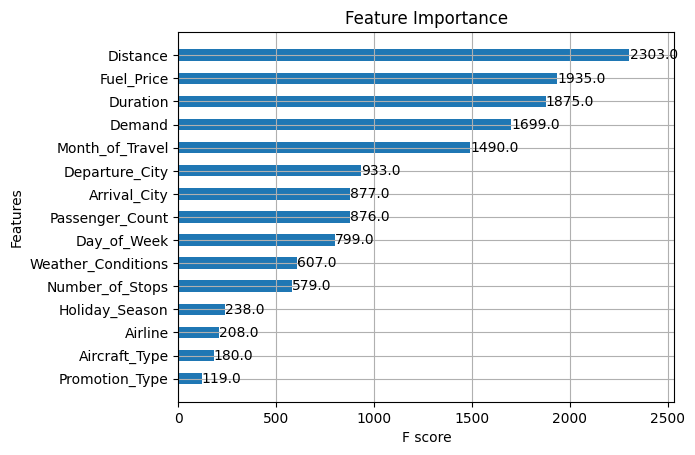

In [ ]:
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(best_xgb_model, importance_type='weight', max_num_features=15, height=0.5)
plt.title('Feature Importance')
plt.show()

In [ ]:
# Load the test dataset
test_data = pd.read_csv('test.csv')

In [ ]:
# Preprocess the test data
test_data_preprocessed = preprocess_data(test_data)

In [ ]:
# Drop unnecessary columns and predict using the trained model
X_test = test_data_preprocessed.drop(columns=['Flight_ID', 'Departure_Time', 'Arrival_Time'])
test_predictions = best_xgb_model.predict(X_test)

In [ ]:
# Add the predictions to the test dataset
test_data['Predicted_Flight_Price'] = test_predictions
test_data[['Flight_ID', 'Predicted_Flight_Price']].head(10)

,Flight_ID,Predicted_Flight_Price
0,F45001,627.651184
1,F45002,913.852173
2,F45003,564.551453
3,F45004,549.228577
4,F45005,650.826416
5,F45006,550.416992
6,F45007,467.530792
7,F45008,857.590698
8,F45009,647.964111
9,F45010,330.947052


In [ ]:
# Load the example submission file to check its format
example_submission = pd.read_csv('submission.csv')
example_submission.head()

,Flight_ID,Flight_Price
0,F45001,NaN
1,F45002,NaN
2,F45003,NaN
3,F45004,NaN
4,F45005,NaN


In [ ]:
# Format the predictions to match the example submission format
formatted_predictions = test_data[['Flight_ID', 'Predicted_Flight_Price']]
formatted_predictions.columns = ['Flight_ID', 'Flight_Price']

In [ ]:
# Save the formatted predictions to a new CSV file
submission_file = 'final_submission.csv'
formatted_predictions.to_csv(submission_file, index=False)
submission_file

'final_submission.csv'